<a href="https://colab.research.google.com/github/miguelangelortizpenaranda/ortizpastorserna/blob/main/bandit_experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grupo 1: Bandido de K-Brazos (Distribución de Bernoulli)

Autores:

- Miguel Ángel Ortiz Peñaranda
- Miguel Pastor Beltrá
- Rubén Serna

## Introducción

El bandido de k-brazos, o k-armed bandit, supone un problema clásico de aprendizaje por refuerzo. En él, disponemos de un número K de elementos que, al activarlos, nos otorgan una recompensa determinada, desconocida a priori. Es esta recompensa la que nos interesa maximizar a lo largo del tiempo, por medio de un método que, bien explore distintos "brazos" o soluciones, bien explote la solución que en un momento dado parezca la mejor, o bien mediante un compendio de ambas prácticas.




## Preparación del entorno

Para el funcionamiento de este notebook por parte de Colab, es necesario ejecutar las líneas de código que se encuentran a continuación,
las cuales se encargan de clonar el repositorio para que el código esté disponible por parte de este notebook.


In [1]:
#!rm -r ortizpastorserna/
#!git clone https://github.com/miguelangelortizpenaranda/ortizpastorserna.git
#!cd ortizpastorserna/

A continuación añadimos al path los directorios de código fuente, tanto para ejecución en Colab como para ejecución en un IDE local.

In [2]:
#@title Importamos todas las clases y funciones
import sys


# Añadir los directorios fuentes al path de Python
sys.path.append('/content/ortizpastorserna/src/eml_k_bandit')
sys.path.append('src/eml_k_bandit')

# Verificar que se han añadido correctamente
print(sys.path)

#!ls


['C:\\Users\\shera\\AppData\\Local\\Programs\\PyCharm\\plugins\\python-ce\\helpers\\jupyter_debug', 'C:\\Users\\shera\\AppData\\Local\\Programs\\PyCharm\\plugins\\python-ce\\helpers\\pydev', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna\\src', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna\\.venv\\Scripts\\python313.zip', 'C:\\Users\\shera\\AppData\\Local\\Programs\\Python\\Python313\\DLLs', 'C:\\Users\\shera\\AppData\\Local\\Programs\\Python\\Python313\\Lib', 'C:\\Users\\shera\\AppData\\Local\\Programs\\Python\\Python313', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna\\.venv', '', 'C:\\Users\\shera\\PycharmProjects\\ortizpastorserna\\.venv\\Lib\\site-packages', '/content/ortizpastorserna/src/eml_k_bandit', 'src/eml_k_bandit']


Realizamos los imports correspondientes a los tipos implementados de variantes del bandido de k-brazos, así como los algoritmos que se han modelado, y algunas otras librerías adicionales para representación de los resultados.

In [3]:

import numpy as np
from typing import List

from algorithms import Algorithm, EpsilonGreedy, UCB1, Softmax
from arms import ArmNormal, ArmBinomial, Bandit
from plotting import get_algorithm_label, plot_average_rewards, plot_optimal_selections, plot_regret

## Metodología de trabajo

Se propone una metodología de trabajo en la que se va a probar, tanto con distintas variantes del bandido de K-brazos (Testearemos parámetros como número de brazos o desviación), como con distintas variantes de los algoritmos que determinan en qué medida el bandido lleva a cabo una función de exploración o de explotación de los brazos, de cara a conseguir la mayor recompensa a lo largo del tiempo. Siendo así, seguiremos los siguientes pasos:

1. En cada experimento que se haga con el bandido, compararemos los algoritmos implementados (Epsilon-Greddy, UCB, Softmax), variando sus parámetros principales. Estos parámetros serán siempre iguales entre distintas ejecuciones, para asegurar la consistencia en el comportamiento de los mismos.
2. Se realizarán variaciones entre: Número de pasos (steps), número de brazos (k), y valor de la desviación en la distribución normal del bandido.
3. Para cada ejecución, se comparará el comportamiento de cada variante del algoritmo atendiendo a las métricas de: Porcentaje de elecciones óptimas en el 20% último de pasos (donde el algoritmo debe acercarse mayormente a la convergencia), y rechazo acumulado para ese algoritmo al final de la ejecución. La cantidad de pasos finales a tener en cuenta para el porcentaje de elecciones óptimas la hemos considerado así para quitarnos el tramo iniciar de los algoritmos donde el comportamiento sea mayoritariamente exploratorio.
4. Para cada experimento, se dará una valoración de los resultados obtenidos.
5. Finalmente, se darán unas conclusiones finales que indiquen qué algoritmo o algoritmos se considera que presentan un mejor comportamiento.


Fijamos la semilla aleatoria para asegurar la reproducibilidad de los resultados de las ejecuciones en distintos dispositivos.

In [4]:
seed = 1234
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

runs = 200 # El número de ejecuciones que utilizamos para promediar resultados va a ser siempre constante en nuestros experimentos

## Experimento

Este código se encarga de ejecutar un número de `runs` concretos para el problema de k-armed bandit. Utilizando una lista de algoritmos y ejecutando cada algoritmo una serie de pasos, para acabar obteniendo un promedio de recompensas por ejecución, así como el porcentaje de selecciones del brazo óptimo para dichas ejecuciones.


In [5]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    """
    Ejecuta el problema del bandido de k-brazos un número de runs concretos, una serie de pasos para cada algoritmo especificado.
    :param bandit: Implementación del bandido de k-brazos a ejecutar
    :param algorithms: Listado de algoritmos a ejecutar para esa implementación del bandido
    :param steps: Número de pasos a ejecutar para cada algoritmo individual
    :param runs: Número de ejecuciones independientes que se va a hacer para todos y cada uno de los algoritmos
    :return: Promedio de recompensas, arrepentimiento acumulado, y porcentaje de soluciones óptimas
    """
    optimal_arm = bandit.optimal_arm  # Se elige el brazo óptimo en base a la implementación del bandido. Necesario para calcular el porcentaje de selecciones óptimas.
    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.
    regrets = np.zeros((len(algorithms), steps)) # Matriz para almacenar el regret
    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms) # Crea una instancia nueva del bandido con la distribución que especifica la implementación pasada como parámetro (normal, binomial)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                optimal_reward = bandit.arms[optimal_arm].get_expected_value() # Recompensa óptima, para calcular regret

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                regrets[idx, step] += (optimal_reward - reward) # Acumulamos arrepentimiento como diferencia entre recompensa óptima y la obtenida
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                 # Modificamos optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                if chosen_arm == optimal_arm:
                  optimal_selections[idx, step] += 1

    # Promediamos recompensas entre ejecuciones
    rewards /= runs

    # Promediamos arrepentimientos entre ejecuciones
    regrets /= runs
    # Calculamos arrepentimiento acumulado a lo largo del array
    cumulative_regret = np.cumsum(regrets, axis=1)

    # Calculamos el porcentaje de selecciones óptimas y almacenar en optimal_selections
    optimal_selections /= runs
    optimal_selections *= 100

    total_steps = optimal_selections.shape[1]
    final_performance = optimal_selections[:, int(total_steps * 0.8):]
    avg_optimal_rates = np.mean(final_performance, axis=1)

    total_regret = cumulative_regret[:, -1] # Coge el ultimo valor

    # Mostrar resultados
    for i, rate in enumerate(avg_optimal_rates):
        print(f"Algoritmo {get_algorithm_label(algorithms[i])}: {rate:.2f}% de elecciones óptimas en el 20% último de steps")
        print(f"Algoritmo {get_algorithm_label(algorithms[i])}: {total_regret[i]:.2f} de arrepentimiento acumulado\n")

    return rewards, cumulative_regret, optimal_selections


## Ejecución del experimento

A continuación, utilizando la función definida anteriormente, vamos a ejecutar el experimento del bandido. Esto se va a realizar para la variante del bandido con distribución de Bernoulli, con una probabilidad entre 0.1 y 0.9 por brazo, y recompensa máxima = 1 por brazo, que es lo que caracteriza a este tipo de distribución. Los "pulls" se van a dividir por tanto únicamente en acierto o rechazo.

Adicionalmente, se va a probar con una serie de algoritmos:
- Epsilon Greedy, con valores de epsilon=[0, 0.01, 0.1], que determinan un comportamiento exploratorio cada vez mayor.
- UCB-1, con c=0.5, c=1, c=2, que determina también el peso de la componente exploratoria en el algoritmo.
- Softmax, con una temperatura de 0.5

Estos algoritmos se van a probar para cada variante del experimento, y mostraremos el promedio de recompensa y el porcentaje de decisiones acertadas para el mejor brazo en cada caso.

Vamos a crear, asimismo, una función que nos permitirá ejecutar el experimento para distinto número de brazos, y distinto número de ejecuciones, para ver si el comportamiento de los algoritmos cambia al modificar estos parámetros

In [6]:

def execute_bandit_experiment(k: int, steps: int, runs: int, bandit: Bandit):
    """
    Ejecuta el experimento para un bandido pasado como parámetro, teniendo en cuenta el número de brazos, cuántas ejecuciones
    queremos promediar, y el número de pasos para los que se va a probar el algoritmo.
    :param k: número de brazos del bandido
    :param steps: número de pasos en los que se va a ejecutar el algoritmo
    :param runs: número de ejecuciones para realizar un promedio de los resultados
    :param bandit: bandido para el que vamos a realizar el experimento
    """
    # Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
    algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1), UCB1(k=k, c=0.5), UCB1(k=k, c=1), UCB1(k=k, c=2), Softmax(k=k, temperature=0.5)]

    print(bandit)
    optimal_arm = bandit.optimal_arm
    print(f"Optimal arm for bandit is: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}\n")
    rewards, regrets, optimal_selections = run_experiment(bandit, algorithms, steps, runs)  # Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
    # Graficar los resultados
    plot_optimal_selections(steps, optimal_selections, algorithms)
    plot_average_rewards(steps, rewards, algorithms)
    plot_regret(steps, regrets, algorithms)


## Ejecución del experimento para Variante 1 del bandido

En primer lugar, vamos a realizar el experimento para una variante del bandido de 10 brazos, con distribución de bernoulli (solo nos devuelve 0 o 1, acierto o error).


In [7]:
# Definimos el bandido (se comparte entre experimentos)
bandit = Bandit(arms=ArmBinomial.generate_arms(k=10, n=1)) # Generar un bandido con k brazos de distribución binomial. El valor de máxima recompensa será 10


### Ejecución de los algoritmos para 1000 steps

Nos disponemos a ejecutar el experimento para 1000 pasos inicialmente.

Bandit with 10 arms: ArmBinomial(n=1, p=0.25), ArmBinomial(n=1, p=0.6), ArmBinomial(n=1, p=0.45), ArmBinomial(n=1, p=0.72), ArmBinomial(n=1, p=0.73), ArmBinomial(n=1, p=0.32), ArmBinomial(n=1, p=0.74), ArmBinomial(n=1, p=0.87), ArmBinomial(n=1, p=0.8), ArmBinomial(n=1, p=0.39)
Optimal arm for bandit is: 8 with expected reward=0.87

Algoritmo EpsilonGreedy (epsilon=0): 55.95% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0): 52.20 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.01): 39.90% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0.01): 212.17 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.1): 77.06% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0.1): 70.86 de arrepentimiento acumulado

Algoritmo UCB1 (c=0.5): 72.88% de elecciones óptimas en el 20% último de steps
Algoritmo UCB1 (c=0.5): 68.28 de arrepentimiento acumulado

Algoritmo UCB1 (c=1):

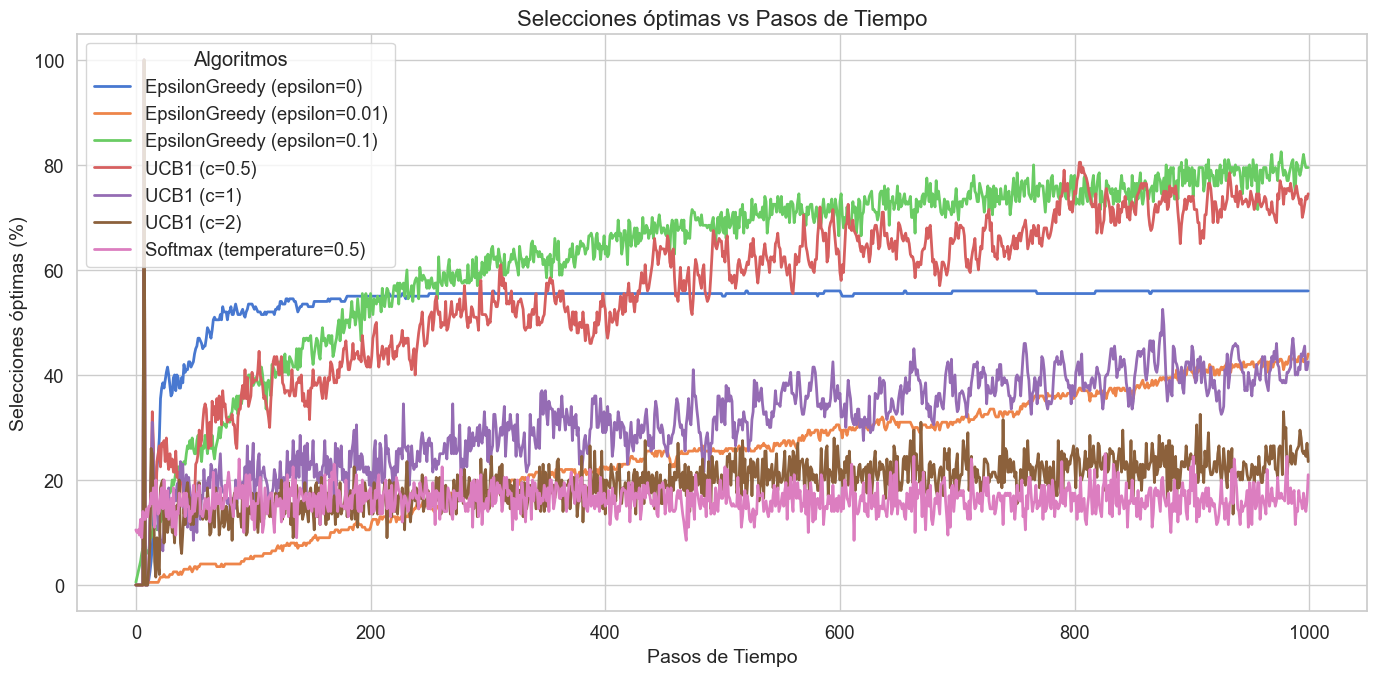

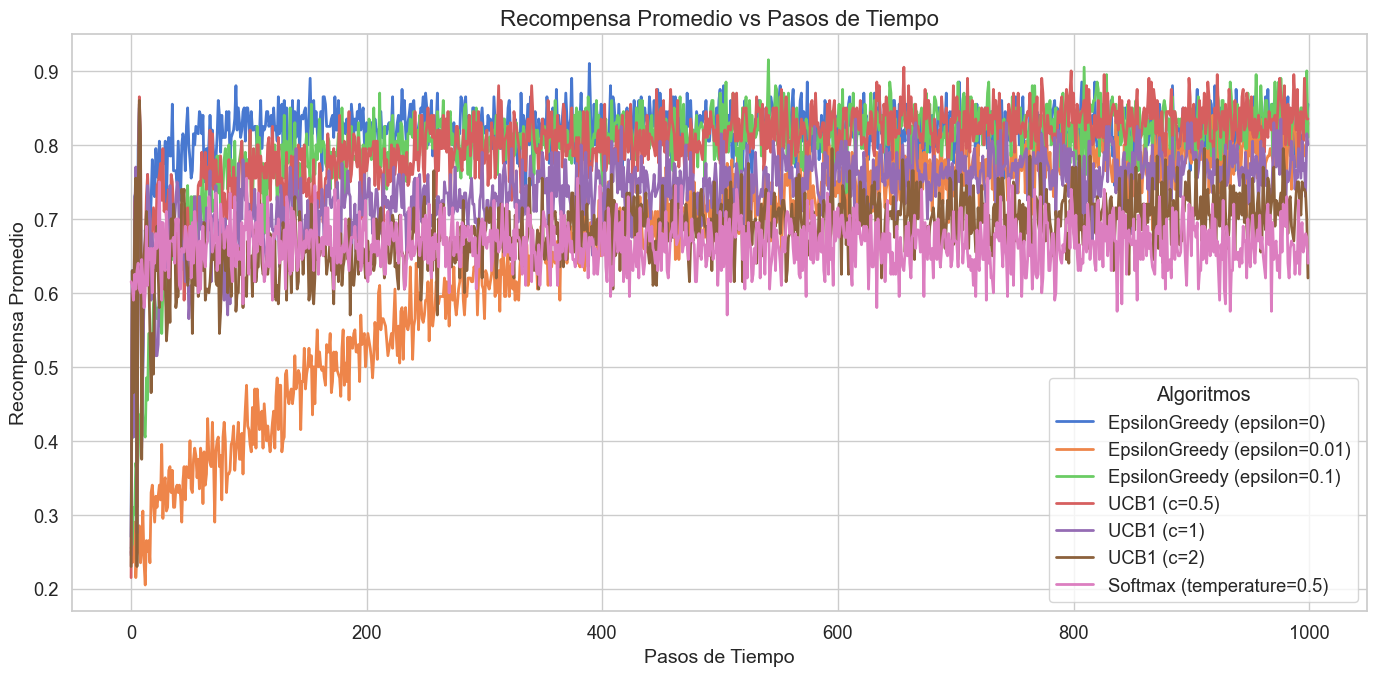

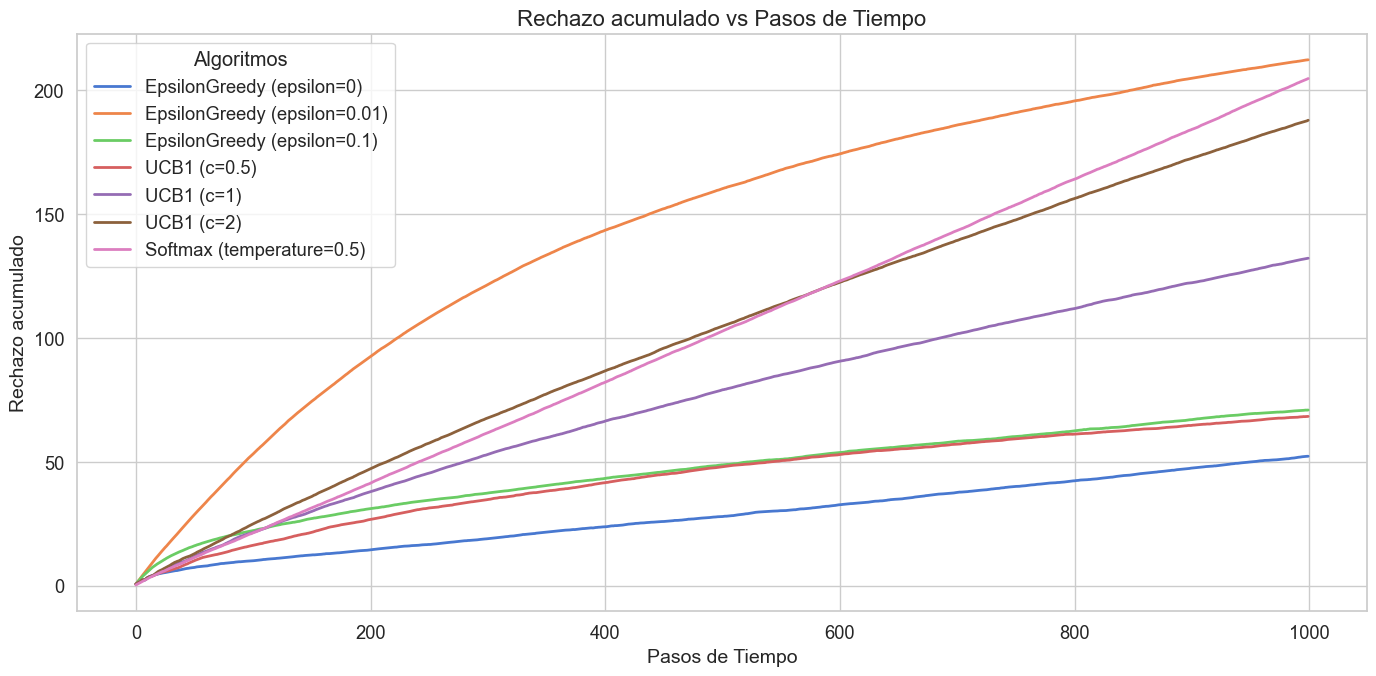

In [8]:
execute_bandit_experiment(k=10, steps=1000, runs=runs, bandit = bandit)

### Valoración de los resultados


### Ejecución de los algoritmos para 2000 steps

A continuación, vamos a repetir el experimento para 2000 pasos, manteniendo el número de runs.

Bandit with 10 arms: ArmBinomial(n=1, p=0.25), ArmBinomial(n=1, p=0.6), ArmBinomial(n=1, p=0.45), ArmBinomial(n=1, p=0.72), ArmBinomial(n=1, p=0.73), ArmBinomial(n=1, p=0.32), ArmBinomial(n=1, p=0.74), ArmBinomial(n=1, p=0.87), ArmBinomial(n=1, p=0.8), ArmBinomial(n=1, p=0.39)
Optimal arm for bandit is: 8 with expected reward=0.87

Algoritmo EpsilonGreedy (epsilon=0): 59.50% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0): 93.59 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.01): 57.65% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0.01): 259.16 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.1): 79.79% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0.1): 114.73 de arrepentimiento acumulado

Algoritmo UCB1 (c=0.5): 83.41% de elecciones óptimas en el 20% último de steps
Algoritmo UCB1 (c=0.5): 95.28 de arrepentimiento acumulado

Algoritmo UCB1 (c=1)

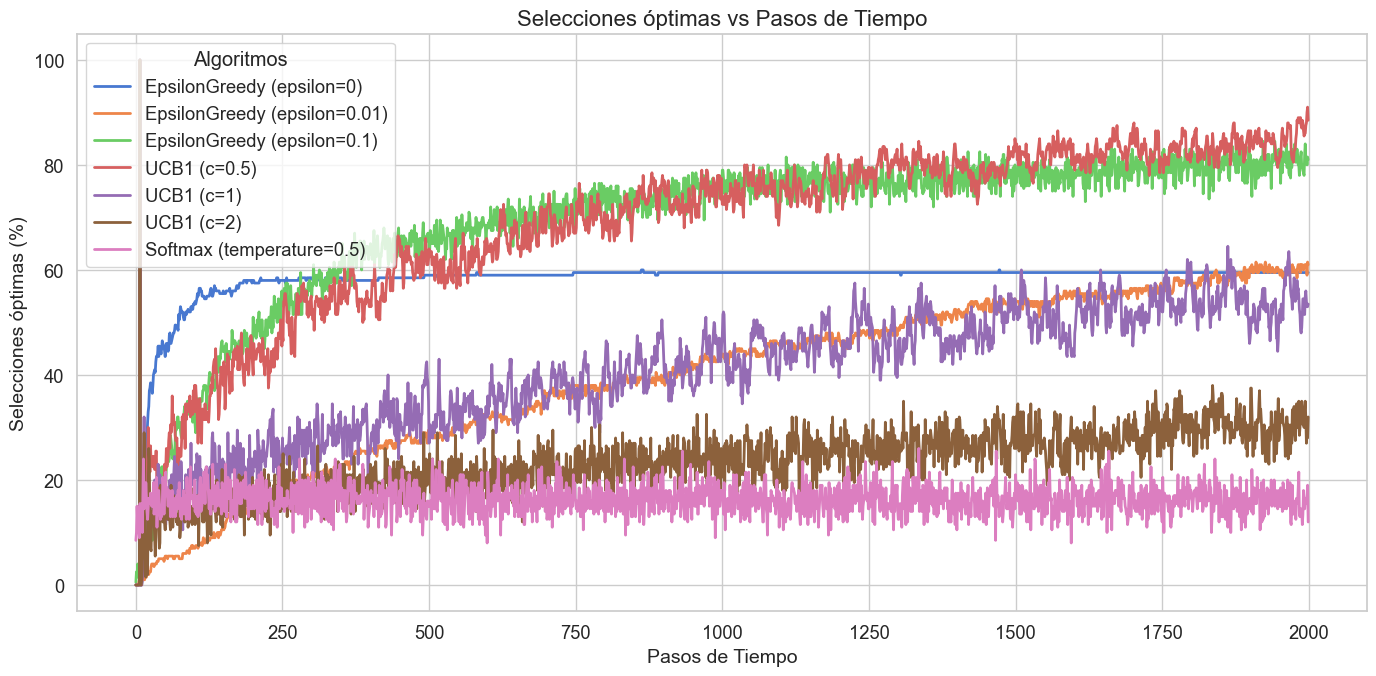

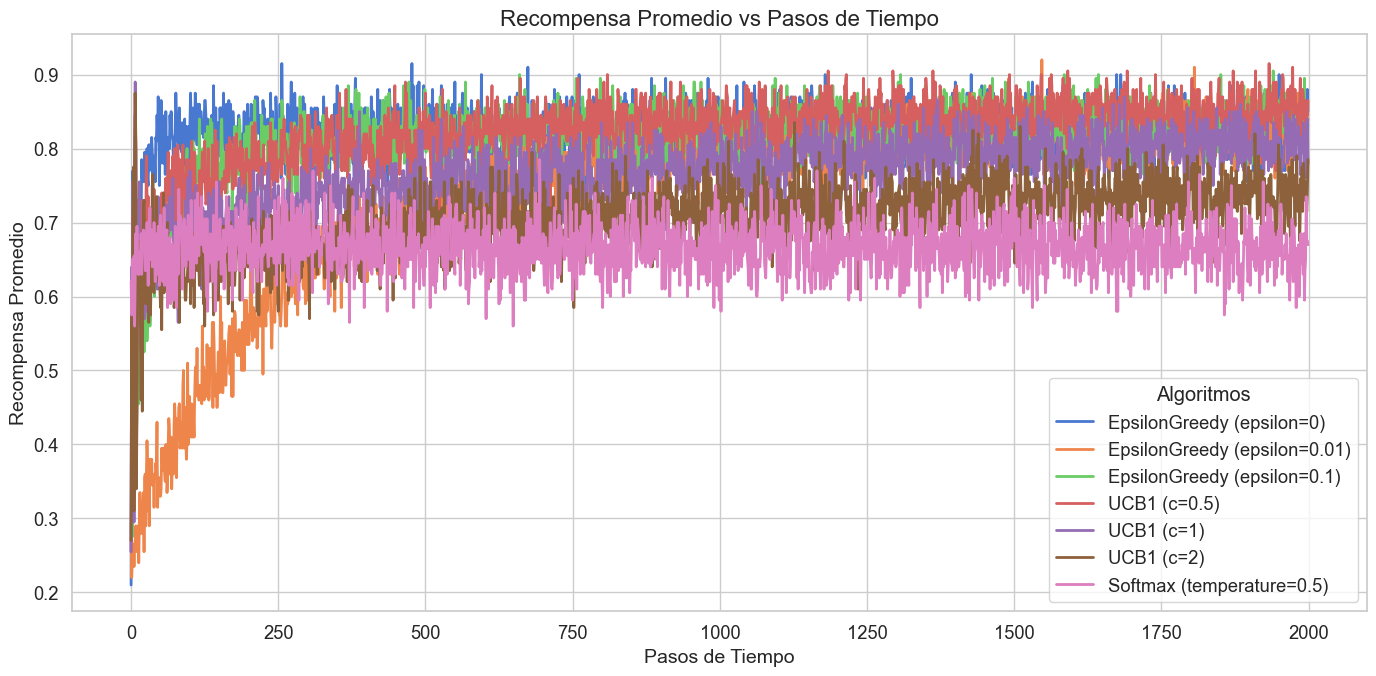

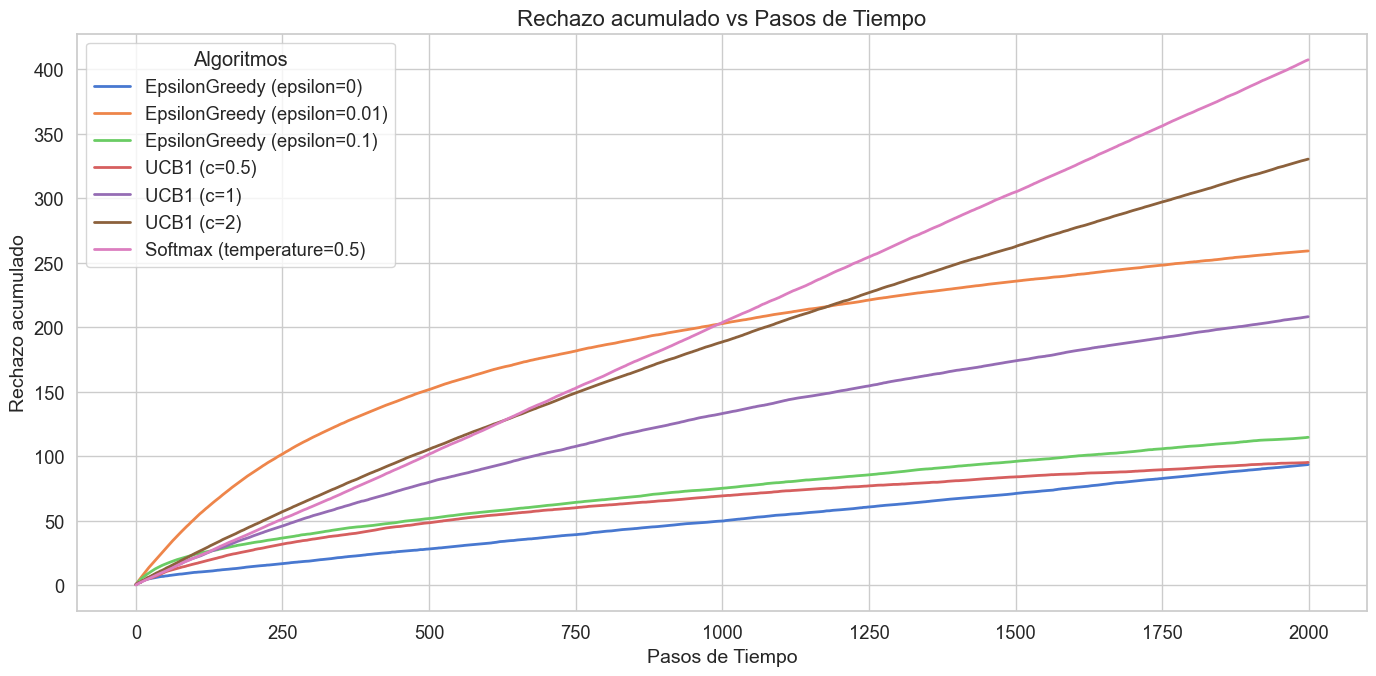

In [9]:
execute_bandit_experiment(k=10, steps=2000, runs=runs, bandit=bandit)


### Valoración de los resultados


## Ejecución del experimento para Variante 2 del bandido

Nos disponemos a realizar el experimento para un bandido de 20 brazos, manteniendo la distribución binomial con valor máximo 10.

In [10]:
# Definimos el bandido (se comparte entre experimentos)
bandit = Bandit(arms=ArmBinomial.generate_arms(k=20, n=1)) # Generar un bandido con k brazos de distribución binomial. El valor de máxima recompensa será 10


### Ejecución de los algoritmos para 1000 steps

Vamos a llevar a cabo el experimento con la nueva variante del bandido para 1000 pasos.

Bandit with 20 arms: ArmBinomial(n=1, p=0.76), ArmBinomial(n=1, p=0.49), ArmBinomial(n=1, p=0.54), ArmBinomial(n=1, p=0.42), ArmBinomial(n=1, p=0.77), ArmBinomial(n=1, p=0.64), ArmBinomial(n=1, p=0.55), ArmBinomial(n=1, p=0.73), ArmBinomial(n=1, p=0.14), ArmBinomial(n=1, p=0.58), ArmBinomial(n=1, p=0.59), ArmBinomial(n=1, p=0.25), ArmBinomial(n=1, p=0.75), ArmBinomial(n=1, p=0.34), ArmBinomial(n=1, p=0.11), ArmBinomial(n=1, p=0.52), ArmBinomial(n=1, p=0.44), ArmBinomial(n=1, p=0.36), ArmBinomial(n=1, p=0.62), ArmBinomial(n=1, p=0.1)
Optimal arm for bandit is: 5 with expected reward=0.77

Algoritmo EpsilonGreedy (epsilon=0): 34.77% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0): 38.67 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.01): 5.08% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0.01): 15.13 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.1): 28.80% de elecciones óptimas en

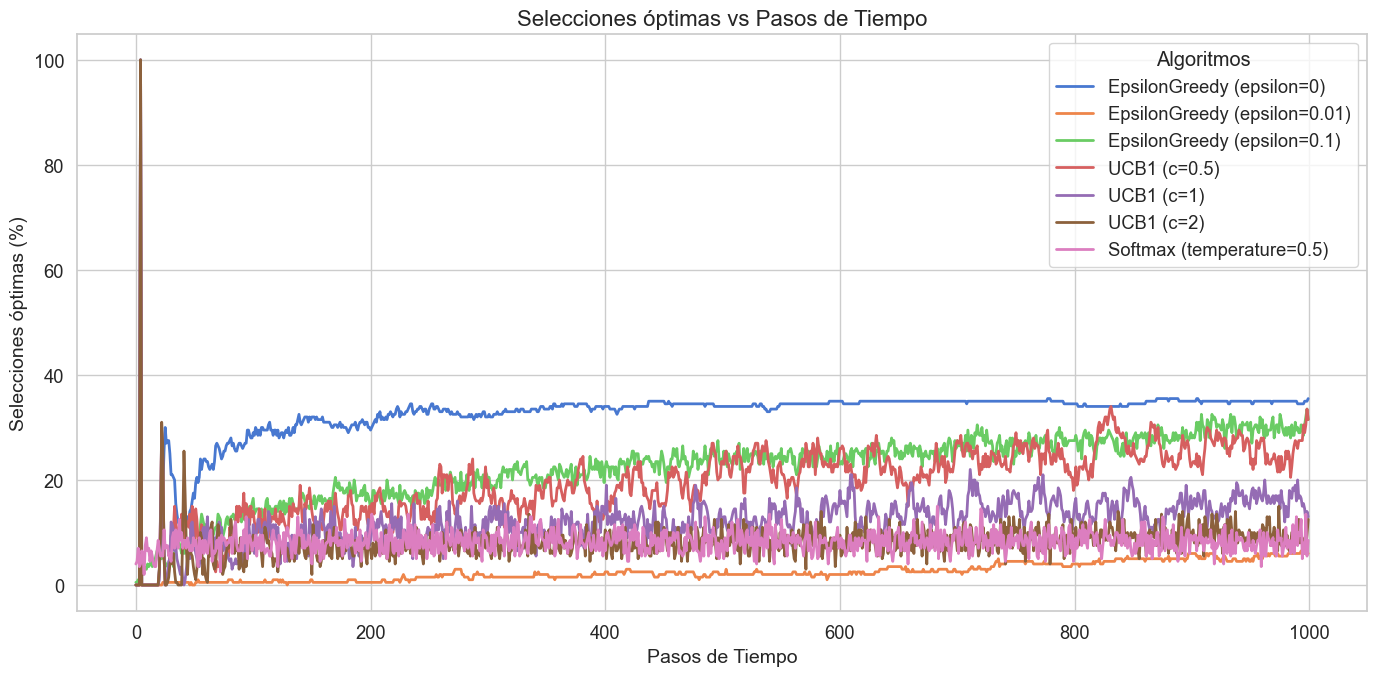

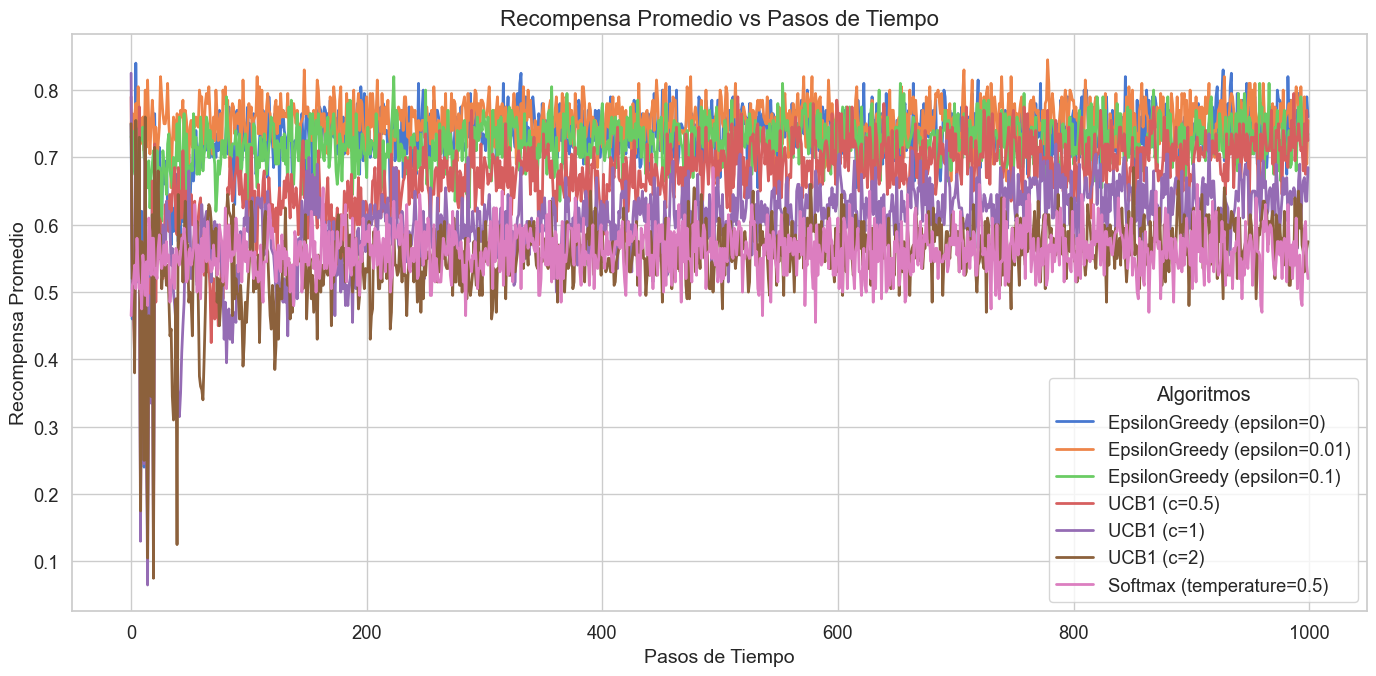

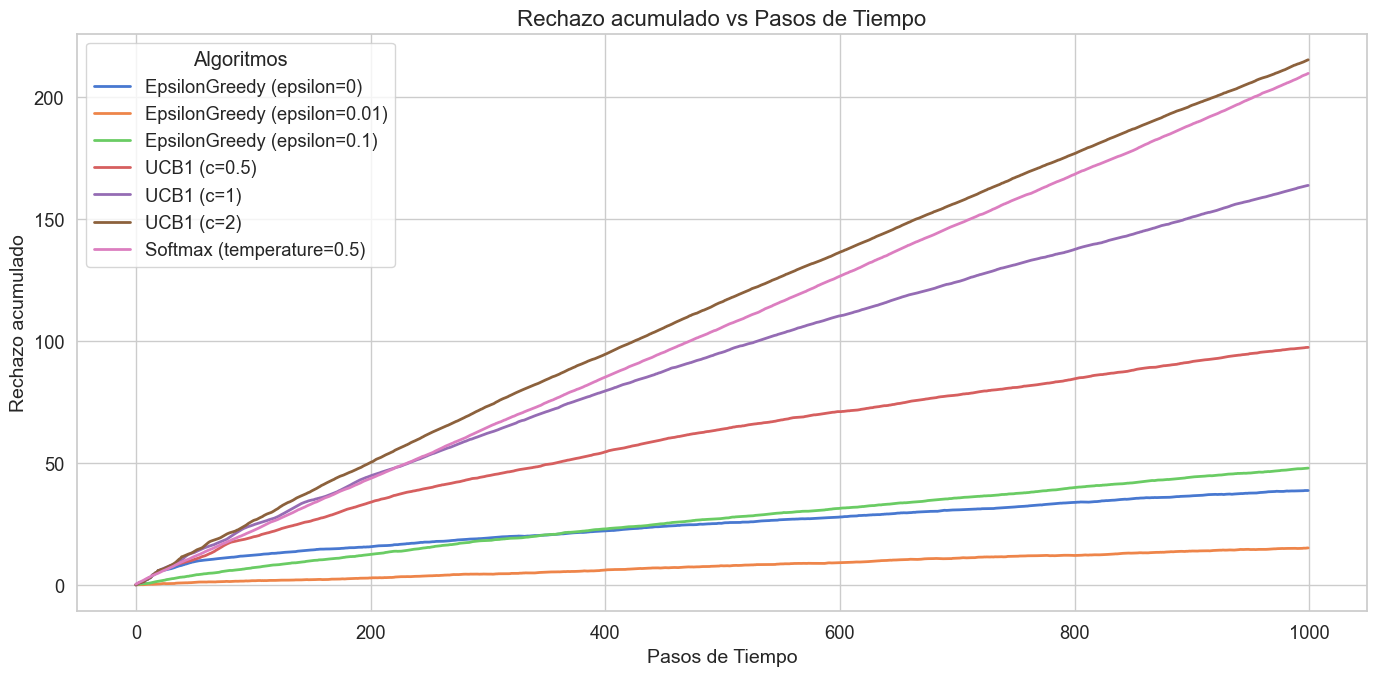

In [11]:
execute_bandit_experiment(k=20, steps=1000, runs=runs, bandit=bandit)

### Valoración de los resultados



### Ejecución de los algoritmos para 2000 steps

A continuación, vamos a repetir el experimento para 2000 pasos, manteniendo el número de runs.

Bandit with 20 arms: ArmBinomial(n=1, p=0.76), ArmBinomial(n=1, p=0.49), ArmBinomial(n=1, p=0.54), ArmBinomial(n=1, p=0.42), ArmBinomial(n=1, p=0.77), ArmBinomial(n=1, p=0.64), ArmBinomial(n=1, p=0.55), ArmBinomial(n=1, p=0.73), ArmBinomial(n=1, p=0.14), ArmBinomial(n=1, p=0.58), ArmBinomial(n=1, p=0.59), ArmBinomial(n=1, p=0.25), ArmBinomial(n=1, p=0.75), ArmBinomial(n=1, p=0.34), ArmBinomial(n=1, p=0.11), ArmBinomial(n=1, p=0.52), ArmBinomial(n=1, p=0.44), ArmBinomial(n=1, p=0.36), ArmBinomial(n=1, p=0.62), ArmBinomial(n=1, p=0.1)
Optimal arm for bandit is: 5 with expected reward=0.77

Algoritmo EpsilonGreedy (epsilon=0): 27.50% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0): 61.29 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.01): 8.09% de elecciones óptimas en el 20% último de steps
Algoritmo EpsilonGreedy (epsilon=0.01): 30.28 de arrepentimiento acumulado

Algoritmo EpsilonGreedy (epsilon=0.1): 23.21% de elecciones óptimas en

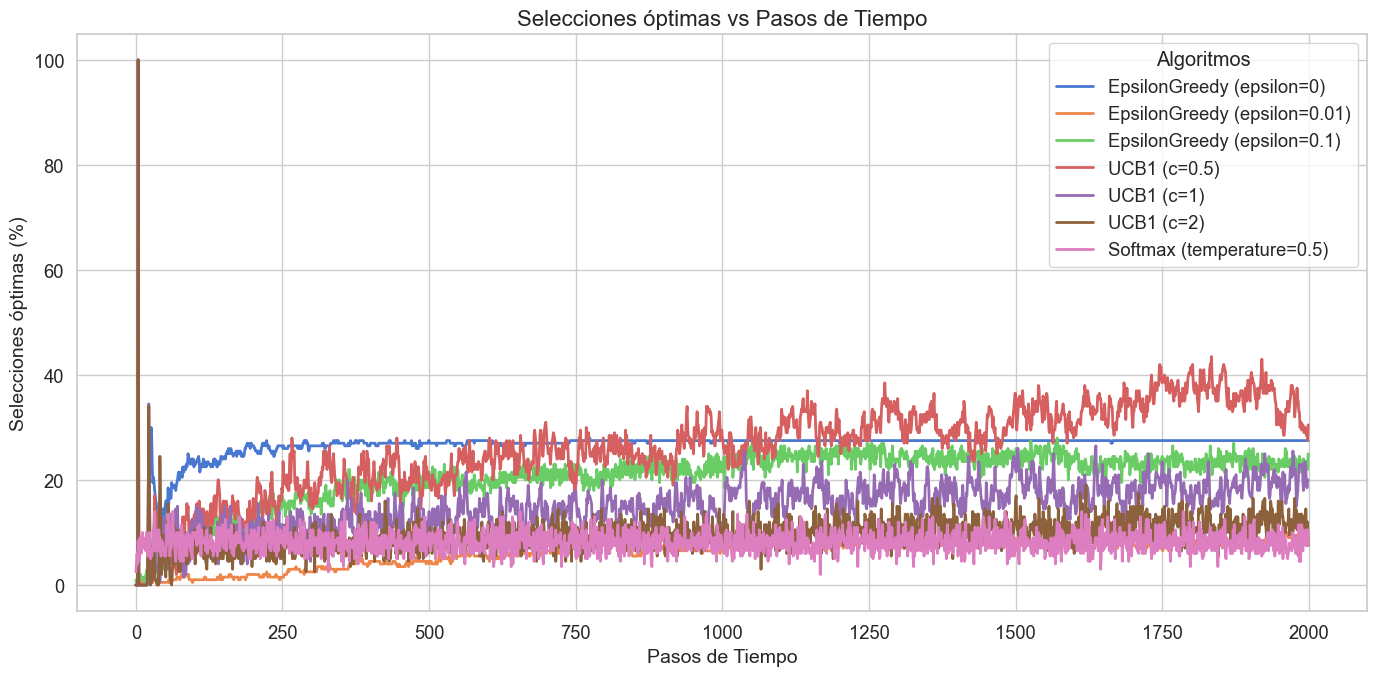

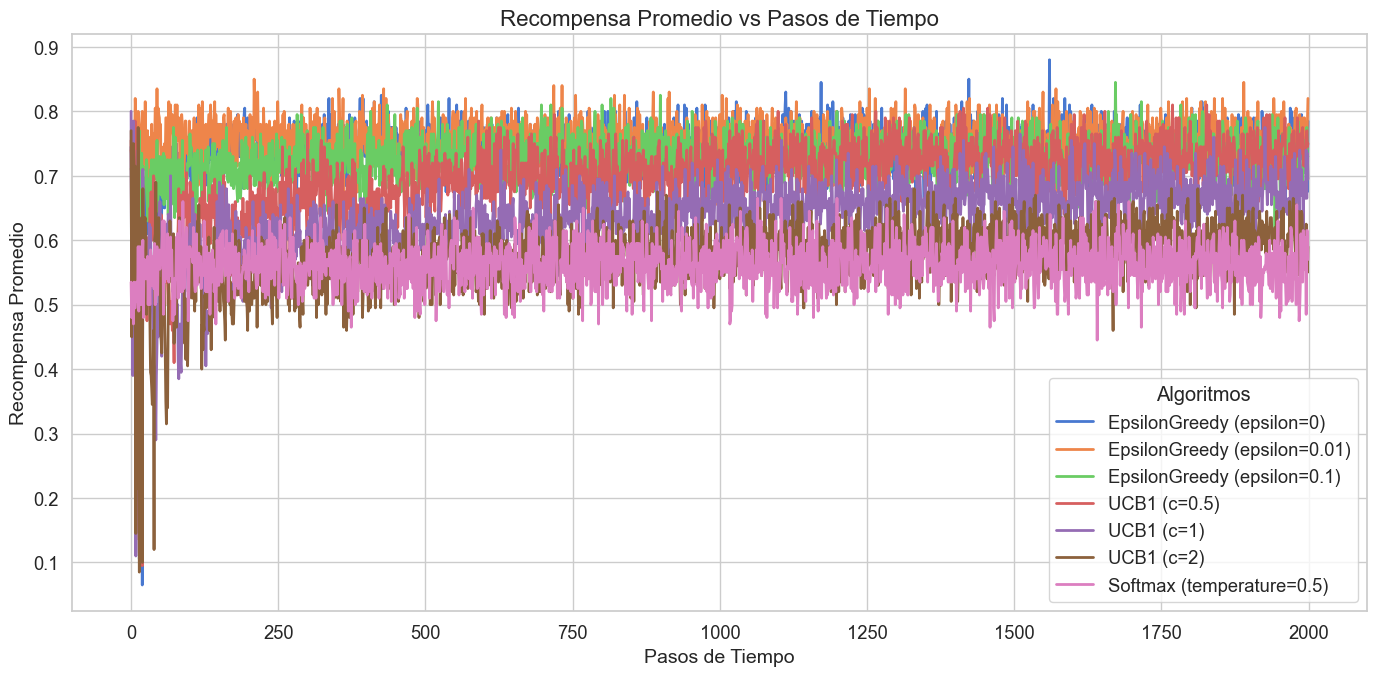

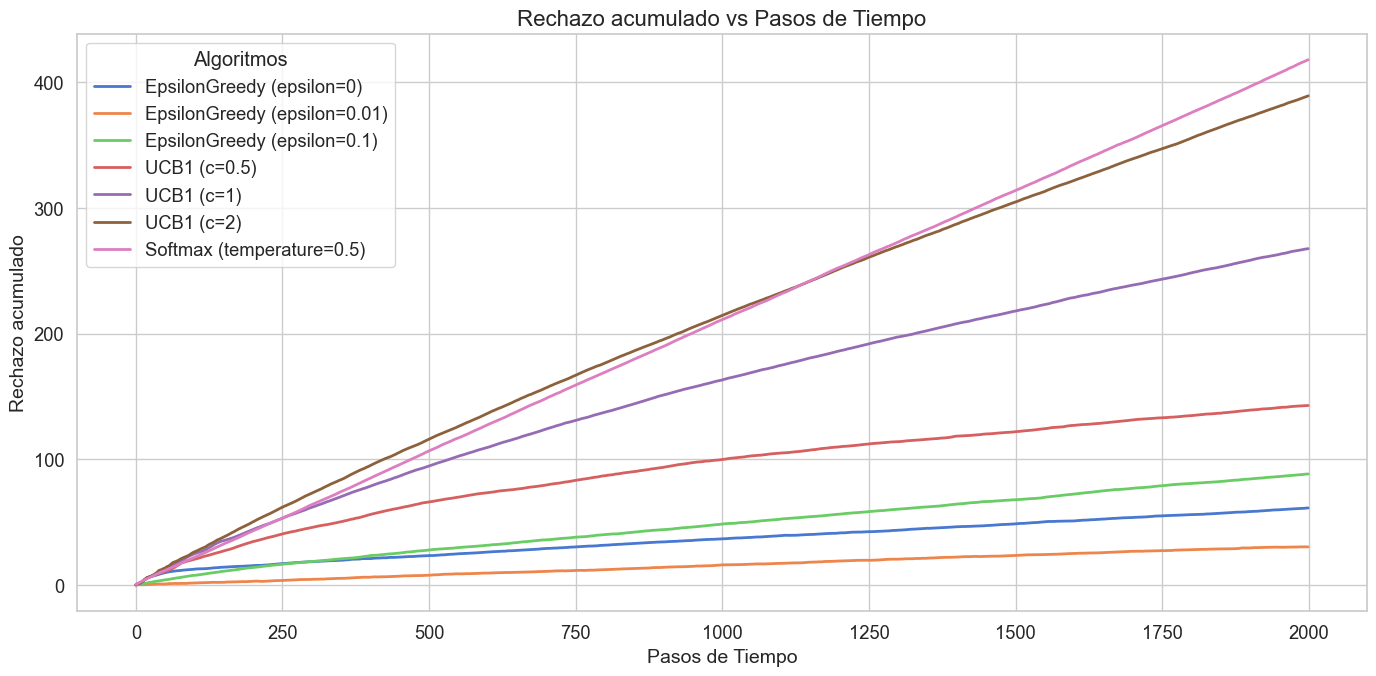

In [12]:
execute_bandit_experiment(k=20, steps=2000, runs=runs, bandit=bandit)

### Valoración de los resultados


## Conclusiones

Hemos realizado distintos experimentos para el bandido de k-brazos siguiendo una distribución de Bernoulli:

*  Experimento para bandido con K=10, steps=1000
*  Experimento para bandido con K=10, steps=2000
*  Experimento para bandido con K=20, steps=1000
*  Experimento para bandido con K=20, steps=2000

En todos los casos se han comparado distintas variantes del algoritmo Epsilon-Greedy, con epsilon=[0, 0.01, 0.1], el algoritmo UCB-1 con c=[0.5, 1, 2], y el algoritmo Softmax. Los parámetros han sido siempre los mismos para asegurar la consistencia de los resultados.

Siendo así, tenemos que, en todos los casos, los algoritmos que mejor comporamiento (Porcentaje de aciertos en último 20% de pasos vs rechazo acumulado) ha presentado han sido los algoritmos UCB-1 con c=0.5 y c=1.

Para los algoritmos Epsilon-Greedy, vemos como interesa tener un nivel de exploración moderado (ej. epsilon=0.1) para obtener los mejores resultados, aunque suelen quedar sensiblemente por debajo de los resultados de UCB-1, y necesitan un número superior de pasos para descubrir el brazo óptimo que UCB.

